In [1]:
# 1: Import data sets and modules
from itables import show
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa as stats_tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
mpl.style.use('seaborn')
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rc('axes',edgecolor='black')
yf.pdr_override()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:
#Import DAX and Adidas (Adjusted) Stock Prices from Yahoo-Finance
tickers = ['^DJI', '^IXIC']


In [14]:
start = dt.datetime(1993, 1, 1)
end = dt.datetime(2019, 12, 31)
df_price = yf.download(tickers, start, end, interval = '1d')['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [6]:
def layout_graph(axes):
    #axes = plt.gca()
    try:
        for ax in axes:
    
            ax.grid(True, which = 'minor', color = 'white', alpha = 0.1)
            ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    
            ax.tick_params(which = 'major', colors = 'black', length = 5, width = 1.2, 
                           labelsize = 'medium')
            ax.tick_params(which = 'minor', length = 3, colors = 'black', width = 0.8)
    
            ax.set_ylabel(None, loc = 'top', fontsize = 'medium')
            ax.set_xlabel(xlabel = None, loc = 'right', fontsize = 'medium')
            ax.grid(True, which = 'minor', color = 'white', alpha = 0.1)

    
    
            for label in ax.get_xticklabels(which='major'):
                label.set(rotation=30, horizontalalignment='right')
    
            ax.tick_params(which = 'major', colors = 'black', length = 5, width = 1.2, 
                           labelsize = 'small')
            ax.tick_params(which = 'minor', length = 3, colors = 'black', width = 0.8)
    except:
        ax = plt.gca()
        ax.grid(True, which = 'minor', color = 'white', alpha = 0.1)
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        ax.tick_params(which = 'major', colors = 'black', length = 5, width = 1.2, 
                       labelsize = 'medium')
        ax.tick_params(which = 'minor', length = 3, colors = 'black', width = 0.8)

        ax.set_ylabel(None, loc = 'top', fontsize = 'medium')
        ax.set_xlabel(xlabel = None, loc = 'right', fontsize = 'medium')
        ax.grid(True, which = 'minor', color = 'white', alpha = 0.1)

        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())



        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        ax.tick_params(which = 'major', colors = 'black', length = 5, width = 1.2, 
                       labelsize = 'small')


In [7]:
def ADF_test(df:pd.DataFrame, ic = 'AIC', reg = 'c'):

    df = df.copy()
    names = df.columns

    print('H0: Series is not stationary vs. H1: Series is stationary.\n')
    for name in names:
        results = {
            'Statistic': ['Series', 'ADF t-statistic', 'P-value', 'Crit. Val. (1%)', 'Crit. Val. (5%)', 
                          'Crit. Val. (10%)', 'Reject H0', ic, 'No. of Lags', 'No. of Obs.'],
            'Value': []
        }
        adf_results = sm.tsa.stattools.adfuller(df[name], autolag = ic, regression = reg)
        
        for key, value in adf_results[4].items():
    
            if abs(adf_results[0]) > abs(adf_results[4][key]):
                interpretation = f'True, α = {key}.'
                break
            else:
                interpretation = 'False'

        results['Value'].append(name)
        results['Value'].append(round(adf_results[0], 4))
        results['Value'].append(round(adf_results[1], 4))
        results['Value'].append(round(adf_results[4]["1%"], 4))
        results['Value'].append(round(adf_results[4]["5%"], 4))
        results['Value'].append(round(adf_results[4]["10%"], 4))
        results['Value'].append(interpretation)
        results['Value'].append(round(adf_results[5], 4))
        results['Value'].append(adf_results[2])
        results['Value'].append(adf_results[3])
        if len(names) > 1 and name == names[0]:
            df_i = pd.DataFrame(data = results)
            df_i.set_index('Statistic', inplace = True)
        else:
            df_j = pd.DataFrame(data = results)
            df_j.set_index('Statistic', inplace = True)
            df_i = pd.concat([df_i, df_j], ignore_index = False, axis = 1)

    columns = [name for name in names]
    df_i = df_i.set_axis(df_i.iloc[0], axis=1)
    df_i.drop('Series', axis = 0, inplace = True)
    return df_i

In [15]:
df_returns = df_price.pct_change()
df_returns.dropna(inplace = True)
df_returns.columns = ['DowJones', 'Nasdaq']
# create a dataframe with the dates
index = pd.date_range(start = df_returns.index[0], end = df_returns.index[-1])
index_df = pd.DataFrame(index = index)
df_returns = index_df.merge(df_returns, how = 'left', left_index = True, right_index = True)

# do interpolation of no-trading days (it is necessary, so the forecast function works)
df_returns = df_returns.interpolate(method='time')

# see retuns
show(df_returns)

In [16]:
show(ADF_test(df_returns))

H0: Series is not stationary vs. H1: Series is stationary.



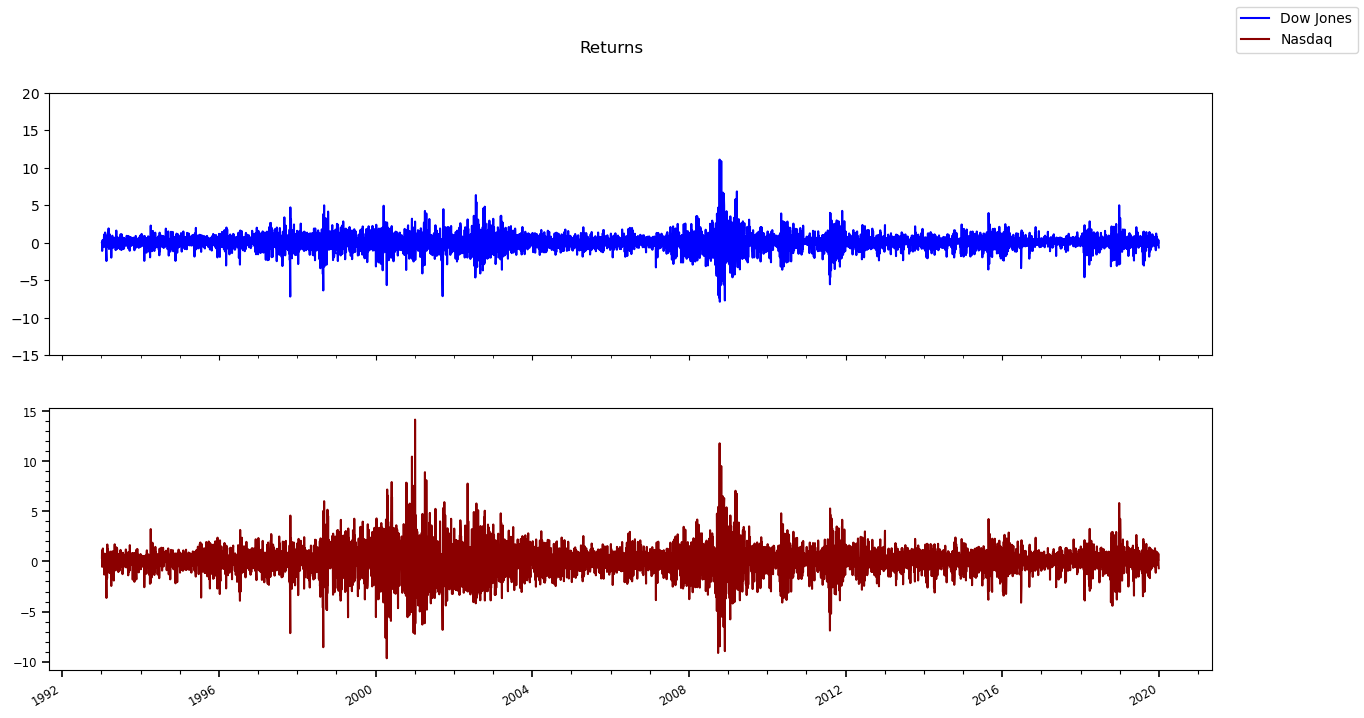

In [17]:
# create axes to hold plots
fig, axes = plt.subplots(2, 1, figsize = (15, 7.5), sharex = True)
label = ['Dow Jones', 'Nasdaq']
color = ['blue', 'darkred']
for i, ax in enumerate(axes):
    ax.plot(df_returns.index, df_returns[df_returns.columns[i]].values * 100, label = label[i], color = color[i])
    layout_graph(ax)


fig.legend()
fig.suptitle('Returns', x=0.5, y=0.95, ha='center', va='top');

y_ticks = axes[1].get_yticks()

axes[0].set_yticks(y_ticks);

In [18]:
df_returns.corr()

,DowJones,Nasdaq
DowJones,1.000000,0.797268
Nasdaq,0.797268,1.000000


In [19]:
from statsmodels.tsa.api import VAR
model = VAR(df_returns)
result_aic = model.select_order() # lets use lag = 34

In [21]:
result_aic.summary()

,AIC,BIC,FPE,HQIC
0,-18.78,-18.78,7.002e-09,-18.78
1,-18.99,-18.99*,5.649e-09,-18.99
2,-18.99,-18.98,5.648e-09,-18.99
3,-18.99,-18.98,5.636e-09,-18.99*
4,-18.99,-18.98,5.638e-09,-18.99
5,-18.99,-18.98,5.639e-09,-18.99
6,-18.99,-18.98,5.635e-09,-18.99
7,-19.00,-18.97,5.631e-09,-18.99
8,-18.99,-18.97,5.633e-09,-18.99
9,-18.99,-18.97,5.634e-09,-18.99


In [22]:
# we choose lag 34 as given by aic and fpe information criteria
lags = 34
VAR_Model = VAR(endog = df_returns, freq = "D", missing = 'none')
# firt the model
results_var = VAR_Model.fit(maxlags = lags)
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Aug, 2024
Time:                     11:42:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.9036
Nobs:                     9822.00    HQIC:                  -18.9704
Log likelihood:           65596.2    FPE:                5.57685e-09
AIC:                     -19.0046    Det(Omega_mle):     5.49931e-09
--------------------------------------------------------------------
Results for equation DowJones
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000297         0.000098            3.035           0.002
L1.DowJones          0.291626         0.017098           17.056           0.000
L1.Nasdaq           -0.009133         0.012445           -0.7

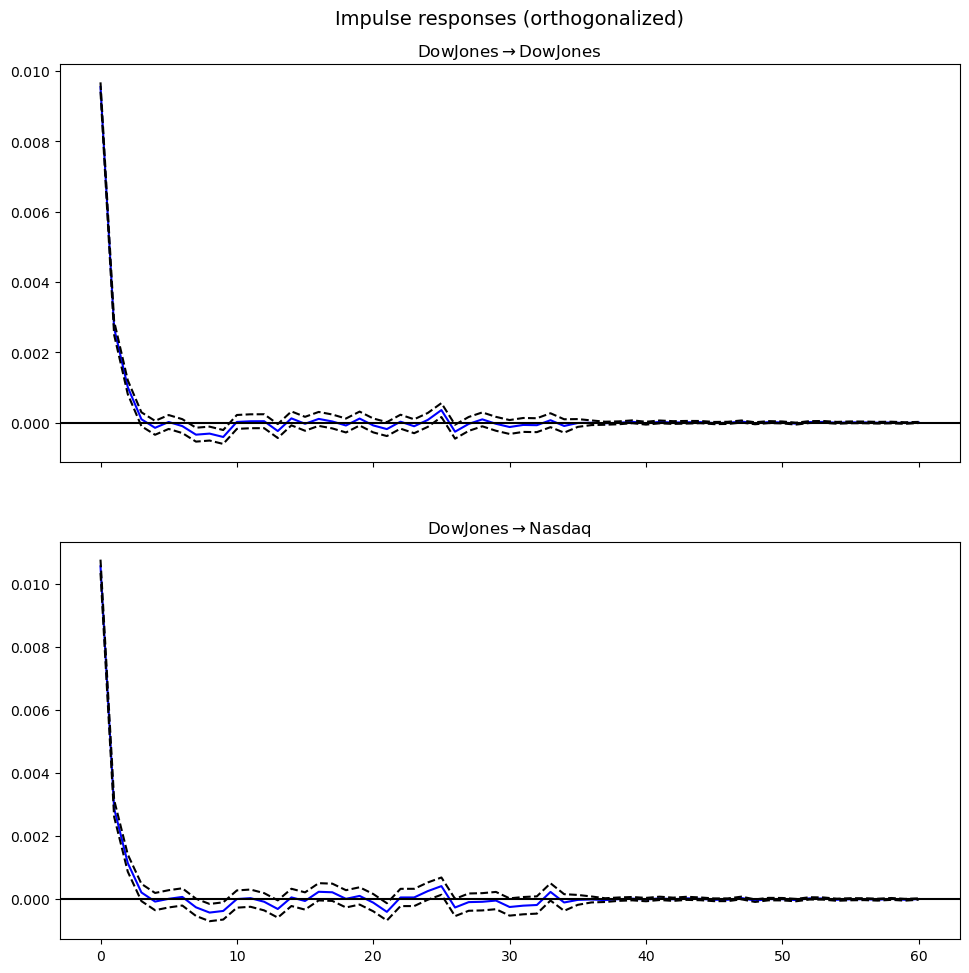

In [23]:

ir = results_var.irf(periods = 60)
impulse_DownJones = ir.plot(impulse = ('DowJones'), seed = 123456, orth = True, repl=1000000000000, );



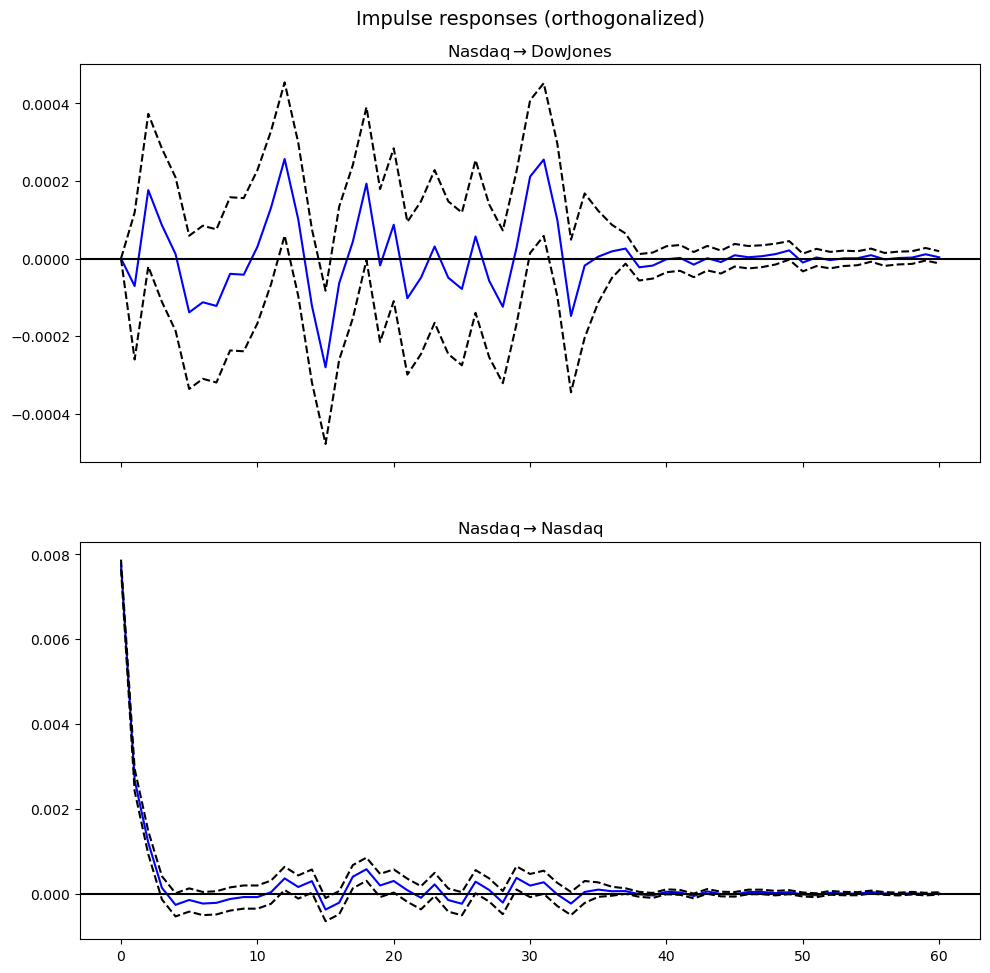

In [24]:
impulse_Nasdaq = ir.plot(impulse = ('Nasdaq'), seed = 123456, orth = True, repl=1000000000000, );

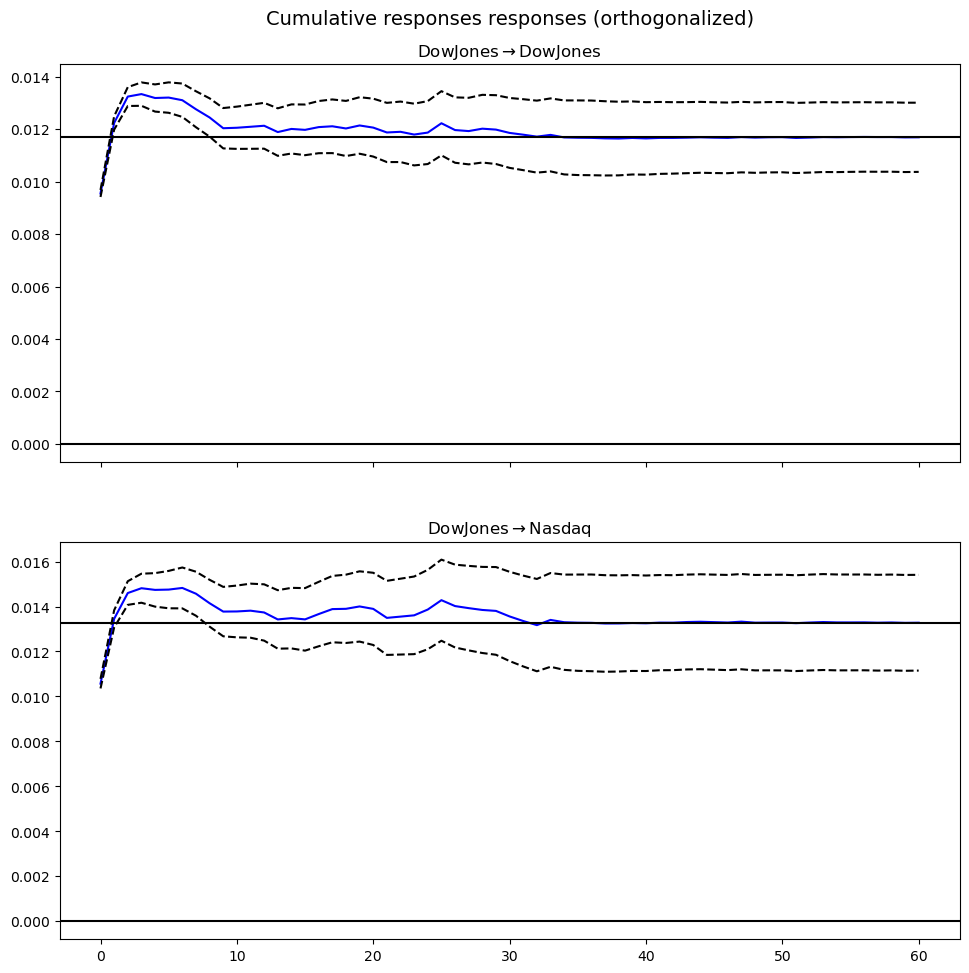

In [25]:


cum_impulse_DowJones = ir.plot_cum_effects(impulse = ('DowJones'), seed = 123456, orth = True, repl=1000000000000);



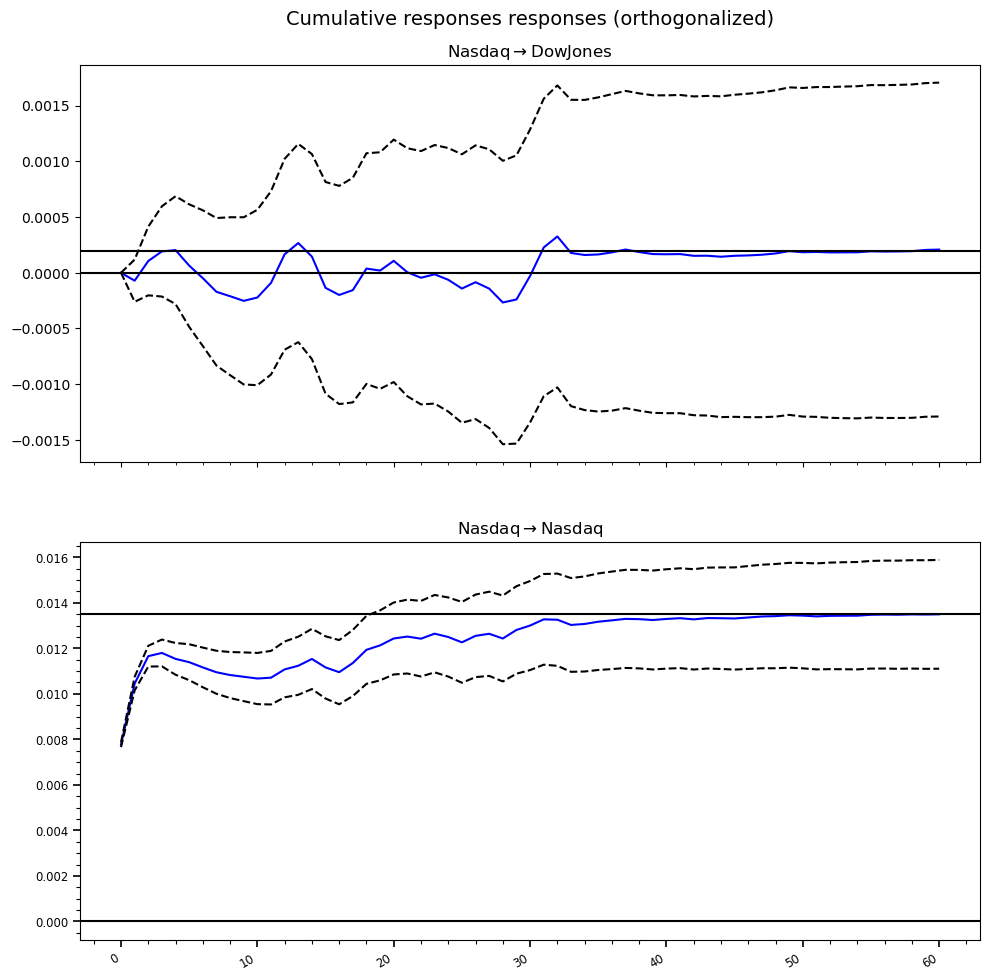

In [26]:
cum_impulse_Nasdaq = ir.plot_cum_effects(impulse = ('Nasdaq'), seed = 123456, orth = True, repl=1000000000000);
layout_graph(cum_impulse_Nasdaq)